# 0N2_Animate_SatImagery

---
Read in and plot thermal infrared image(s) from MODIS and VIIRS level1b radiances. 

Overlay ERA5 atmospheric reanalysis surface atmospheric conditions (doi: 10.24381/cds.adbb2d47) and SIDEx buoy positions. 

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

from LIB_plot_sat import *
from LIB_plot_VIIRS import *
from LIB_plot_MODIS import *

import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from pyproj import Geod
g = Geod(ellps='WGS84')

## Import level1b MODIS files (HDF and GEO)
Download from: https://ladsweb.modaps.eosdis.nasa.gov/

In [239]:
# set paths for location of level1b hdf and geolocation files
# set provided folder type as path to folder and other as []
MainFolder = [] 
SingleFolder = []
#==============================================================
MainFolder = '/Users/mackenziejewell/Desktop/filenames/download2/'
# SingleFolder = '/Users/mackenziejewell/Desktop/temp/VIIRS/'
# SingleFolder = '/Users/mackenziejewell/Desktop/filenames/plot/2021085/'
#==============================================================


#==============================================================
sensor = 'VIIRS'
# sensor = 'MODIS'
#==============================================================

if str(sensor) == 'VIIRS':
    satellite_labels = [('VNP03MOD','VNP02MOD'), ('VJ103MOD','VJ102MOD')]
elif str(sensor) == 'MODIS':
    satellite_labels = [('MOD03','MOD021KM'), ('MYD03','MYD021KM')]

Image_Meta_paired = pair_images_meta(MainFolder = MainFolder, SingleFolder = SingleFolder, 
                                     sensor = sensor, satellite_labels = satellite_labels,
                                     min_geofile_sizeMB = 28, min_imfile_sizeMB = 50, max_diff_minutes = 20)
    

Search within main folder: /Users/mackenziejewell/Desktop/filenames/download2/
Pair 0
------
2021-04-23 23:00:00

Pair 1
------
2021-04-24 12:36:00
2021-04-24 12:42:00

Pair 2
------
2021-04-24 16:00:00

Pair 3
------
2021-04-24 20:06:00
2021-04-24 20:12:00

Pair 4
------
2021-04-24 22:36:00
2021-04-24 22:42:00

Pair 5
------
2021-04-25 12:18:00
2021-04-25 12:24:00

Pair 6
------
2021-04-25 15:36:00
2021-04-25 15:42:00

Pair 7
------
2021-04-25 20:42:00

Pair 8
------
2021-04-25 23:12:00

Pair 9
------
2021-04-26 12:00:00
2021-04-26 12:06:00

Pair 10
------
2021-04-26 15:18:00
2021-04-26 15:24:00

Pair 11
------
2021-04-26 20:18:00
2021-04-26 20:24:00

Pair 12
------
2021-04-26 22:00:00
2021-04-26 22:06:00

Pair 13
------
2021-04-27 12:30:00
2021-04-27 12:36:00

Pair 14
------
2021-04-27 15:54:00

Pair 15
------
2021-04-27 20:00:00
2021-04-27 20:06:00

Pair 16
------
2021-04-27 22:30:00
2021-04-27 22:36:00

Pair 17
------
2021-04-28 12:12:00
2021-04-28 12:18:00

Pair 18
------
2021-04-

## Specify which pairs of images to plot

In [240]:
# specify which pairs of images to plot
# either 'All' or index(es) of images to plot (e.g. [1,3,6])
#==============================================================
# RunPair = [1] 
# RunPair = np.arange(19, 63) 
RunPair = 'All'
#==============================================================

## ECMWF data

In [241]:
# name and directory for ECMWF atmospheric data (nc file type)
# or set = None if you don't want to include
#==============================================================
# ECMWF = None
ECMWF = '/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc'
#==============================================================


## Buoy coordinate data

In [242]:
# set list of path+name of csv files containing coordinates
# or set = None if not adding buoy coordinates
#==============================================================
# csv_directory = None
buoy_file = './data/BuoyCoordinates_cln_v0.nc'
#==============================================================
ds = xr.open_dataset(buoy_file)
ds.close()
buoy_time = pd.to_datetime(ds.time.values)


from LIB_SIDExbuoy import open_buoy_data, calc_velocity, calculate_velocity

def grab_buoy_velocities(ImageDate, ds, buoy_time):
    
    # find index nearest to date
    nearest_ind = np.argmin(np.abs((buoy_time - ImageDate)))
    time_slice = buoy_time[nearest_ind-1:nearest_ind+2]

    # grab all buoy coords and velocities
    all_buoys = ds.buoyID.values
    buoy_lons = np.array([])
    buoy_lats = np.array([])
    buoy_u = np.array([])
    buoy_v = np.array([])
    
    for buoy in all_buoys:
    
        crop_time = ds.sel(time=time_slice).sel(buoyID=buoy)

        # calc velocity
        out = calculate_velocity(lons = crop_time.longitude.values, lats = crop_time.latitude.values, 
                                 times = pd.to_datetime(crop_time.time.values), method = 'centered')
        u, v, sp, time, lat, lon, dx, dy, di, az, dt = out

        if len(u) == 0:
            buoy_lons = np.append(buoy_lons, np.nan)
            buoy_lats = np.append(buoy_lats, np.nan)
            buoy_u = np.append(buoy_u, np.nan)
            buoy_v = np.append(buoy_v, np.nan)

        else:
            buoy_lons = np.append(buoy_lons, lon)
            buoy_lats = np.append(buoy_lats, lat)
            buoy_u = np.append(buoy_u, u.magnitude)
            buoy_v = np.append(buoy_v, v.magnitude)

    return buoy_lons, buoy_lats, buoy_u, buoy_v


# function to interpolate ERA5 winds local to each buoy

import bisect
from scipy.interpolate import RegularGridInterpolator

def interpolate_uv(ds = [], interp_lon = 100, interp_lat = 70, 
                   variables = ['u10', 'v10'],
                   buffer_lon = 1, buffer_lat = 1):

    """Interpolate data variables over specific points on lat/lon grid.
    This uses scipy RegularGridInterpolator so does not take into account true distances 
    between regularly gridded geo data points, but should be close enough!
    
    ds: xarray dataset with 'longitude' and 'latitude' coordinates, and variables
    interp_lon: longitude to interpolate ds data variables at
    interp_lat: latitude to interpolate ds data variables at
    variables: (Lx1) list of data variable names in ds to interpolate
    
    OUTPUT:
    - values: (Lx1) list of inteprolated values from data variables
    """
    

    # create buoy coordinate data 
    interp = {}
    interp['latitude'] = interp_lat
    interp['longitude'] = interp_lon

    # reverse coordinates if not ascending
    if ds['latitude'][0] > ds['latitude'][1]:
        ds = ds.sortby('latitude', ascending=True)   
    if ds['longitude'][0] > ds['longitude'][1]:
        ds = ds.sortby('longitude', ascending=True)   

    # find coordinates within buffer of desired coords
    lon_ind = bisect.bisect_left(ds['longitude'], interp['longitude'])
    local_lons = ds['longitude'][lon_ind-buffer_lon:lon_ind+buffer_lon+1]
    lat_ind = bisect.bisect_left(ds['latitude'], interp['latitude'])
    local_lats = ds['latitude'][lat_ind-buffer_lat:lat_ind+buffer_lat+1]

    # crop ds around desired point
    local_ds = ds_era.sel(longitude=local_lons, latitude=local_lats)
    ds_dims = local_ds[variables[0]].dims

    # name as x,y coordinates and create grid
    x = local_ds[ds_dims[0]].values.astype(np.float64) 
    y = local_ds[ds_dims[1]].values.astype(np.float64)

    values = []

    for var in variables:

        # create interpolation function and interpolate data at desired point
        d = local_ds[var].values.astype(np.float64)
        interpolation = RegularGridInterpolator((x, y), d, bounds_error=False, fill_value=None)
        val = interpolation((interp[ds_dims[0]], interp[ds_dims[1]]))
        values.append(val)

    return values

## Specify other plot parametres and layers

In [243]:
# PLOT PARAMETERS

# set plot range and map_projection
#==============================================================
lat_range = [69.5, 78]
lon_range = [197, 232]
extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
#==============================================================

# specify band of data to plot
#==============================================================
if str(sensor) == 'MODIS':
    band = '31'   # Thermal MODIS: Infrared (TIR) at 10.780â€“11.280 micrometers
elif str(sensor) == 'VIIRS':
    band = 'M15'  # Thermal VIIRS: longwave IR 10.26 - 11.26 micrometers
#==============================================================


# set colorscale for image
#==============================================================
ice_cmap = mpl.cm.Blues
# ice_cmap = cmocean.cm.ice_r
#==============================================================


# whether or not to suppress prints
#==============================================================
quiet = True
#==============================================================

# hide known warnings that result in many printed warning statements
#==============================================================
# ignore shapely warning for geographic plots
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
# pcolormesh shading warning
warnings.filterwarnings("ignore", module = "matplotlib\..*" )
warnings.filterwarnings("ignore", module = "cartopy\..*" )
#==============================================================




In [244]:
def flatten_pair_data(lat, lon, _image_):
    
    all_lats = np.array([])
    all_lons = np.array([])
    all_rad = np.array([])

    all_lats = np.append(all_lats, lat[0].flatten())
    all_lons = np.append(all_lons, lon[0].flatten())
    all_rad = np.append(all_rad, _image_[0].flatten())
    
    if len(lat) == 2:
        all_lats = np.append(all_lats, lat[1].flatten())
        all_lons = np.append(all_lons, lon[1].flatten())
        all_rad = np.append(all_rad, _image_[1].flatten())
        
    return all_lats, all_lons, all_rad

## make plot

In [245]:


FS = 12




starttime = datetime.now()

# RUN TO MAKE PLOT, ADJUST APPEARANCE OF LAYERS BELOW AS NEEDED
#==============================================================

# Run through all pairs of images given in RunPair and make plots
#----------------------------------------------------------------
if str(RunPair) == 'All':
    RunPair = np.arange(0,np.max(Image_Meta_paired[:,4])+1)
for ii in RunPair:
    # grab metadata from current_set of paired images
    #------------------------------------------------
    # grab current_set of paired images to run through
    current_set = Image_Meta_paired[np.where(Image_Meta_paired[:,4]==ii)[0]]
    # start empty lists to fill with image names, paths, and dates
    IMG_filename=[]
    GEO_filename=[]
    # add data from all images in current_set to above lists
    counter = 0
    for image_meta in current_set:
        # grab date and ImageName for saving from first file in current_set
        if counter == 0:
            ImageDate = image_meta[0]
            ImageName = image_meta[3]+image_meta[2][0:22]
        IMG_filename = np.append(IMG_filename, image_meta[3]+image_meta[2])
        GEO_filename = np.append(GEO_filename, image_meta[3]+image_meta[1])
        counter+=1
    

    if not quiet:
        print('Save with name {}'.format(ImageName))    
        print('Image is from: {} UTC (day {} of {})'.format(ImageDate,ImageDate.strftime('%j'), ImageDate.strftime('%Y')))
    # grab data from current_set of paired images
    #--------------------------------------------
    # start empty lists to fill with imagery data and coordinates
    _image_ = []
    lat = []
    lon = []

    # for all images in current_set
    for jj in range(len(current_set)):

        # import imagery data, mask invalid values
        # and import geo data
        #-----------------------------------------

        if str(sensor) == 'MODIS':
            _level1bimage_ = load_MODISband(IMG_filename[jj], 'EV_1KM_Emissive', band, 'radiance')
            LAT, LON = get_MODISgeo(GEO_filename[jj])

        elif str(sensor) == 'VIIRS':
            _level1bimage_ = load_VIIRS_band(IMG_filename[jj], band = 'M15')
            LAT, LON = get_VIIRS_geo(GEO_filename[jj])


        # add imagery and coordinates for this file to the lists
        #-------------------------------------------------------
        _image_.append(_level1bimage_)
        lat.append(LAT)
        lon.append(LON)

    # determine rounded image date to 0Z, 4Z, 8Z, 12Z, 16Z, 20Z
#     date_only = pd.to_datetime(ImageDate.date())
#     hours = (ImageDate - date_only).total_seconds()/3600
#     if (hours < 2):
#         mod_date = date_only
#     elif (hours > 2) and (hours < 5.9):
#         mod_date = date_only + timedelta(hours=4)
#     elif (hours > 5.9) and (hours < 10):
#         mod_date = date_only + timedelta(hours=8)
#     elif (hours > 10) and (hours < 14):
#         mod_date = date_only + timedelta(hours=12)
#     elif (hours > 14) and (hours < 18):
#         mod_date = date_only + timedelta(hours=16)
#     elif (hours > 18) and (hours < 22):
#         mod_date = date_only + timedelta(hours=20)
#     elif (hours > 22):
#         mod_date = date_only + timedelta(hours=24)
    
#     mod_date = mod_date.to_pydatetime()
#     rounded_date = ImageDate-timedelta(minutes = ImageDate.minute)
    
    nearest_hour_date = ImageDate.replace(second=0, microsecond=0, minute=0, hour=ImageDate.hour) + timedelta(hours=ImageDate.minute//30)
    


    #==============
    # PLOT IMAGERY
    #==============
    # create figure
    #--------------
    # dynamic color scale
    all_lats, all_lons, all_rad = flatten_pair_data(lat, lon, _image_)
    all_rad[all_rad.data == 65533] = np.nan

    cond = (all_lats > 70).astype(int)+(all_lats < 77).astype(int)+(all_lons > 200).astype(int)+(all_lons < 240).astype(int)
    min_val = np.nanpercentile(all_rad.data[cond == 4], 1)-0.1
    max_val = np.nanpercentile(all_rad.data[cond == 4], 99)+0.75
    cscale = [min_val, max_val]
    divnorm=matplotlib.colors.TwoSlopeNorm(vmin=min_val, vcenter=min_val+0.7*(max_val-min_val), vmax=max_val)

    sp = 5
    fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection), figsize=(8,8), facecolor='white')
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN, color=ice_cmap(0.3), zorder=0)



    for ii in range(0,len(_image_)):
        ax.pcolormesh(lon[ii], lat[ii], _image_[ii],norm = divnorm,
                      cmap=ice_cmap, shading='nearest', zorder=1, transform=ccrs.PlateCarree())
        
#     plot_singleband_sat(ax,  lat, lon, _image_, cmap=ice_cmap, cscale=cscale, 
#                         shading='nearest', zorder=1)

    #======================
    # ADD CARTOPY FEATURES
    #======================
    add_land(ax,  scale='10m', color=[0.85,0.85,0.85], alpha=1, fill_dateline_gap=True, zorder=3)
    add_coast(ax, scale='10m', color=[0.8,0.8,0.8], linewidth=1, alpha=1, zorder=4)
#     add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=10)


    # label date
    #======================
    add_date(fig, ax, nearest_hour_date, date_format='%Y-%m-%d %H:00',
             boxstyle='round,pad=0.2,rounding_size=0.2',
             method='manual', facecolor='white', edgecolor='None',
             x = 0.0, y = 1.05, textcolor='k', fontsize=FS+3, zorder=10)

    # import era5
    #=============
    # grab nearest date index from ECMWF file
    if not quiet:
        print('Add wind data: nearest date ECMWF --> {}'.format(nearest_hour_date))
    ds_era = xr.open_dataset(ECMWF).sel(time=nearest_hour_date)
    ds_era.close()
    u10  = ds_era.u10.values
    v10  = ds_era.v10.values
    msl  = ds_era.msl.values/100
    Lons, Lats = np.meshgrid(ds_era.longitude.values, ds_era.latitude.values)


    # wind vectors
    #======================
    wind_vec = ax.quiver(Lons, Lats, *fix_cartopy_vectors(u10, v10, Lats),
                        regrid_shape=7, scale=150, width=0.003, color=[0.4,0.4,0.4], headwidth=4, pivot='mid',
                        headaxislength=3, headlength=5, transform=ccrs.PlateCarree(), zorder=8)
    qk = ax.quiverkey(wind_vec, 0.485, 1.02, 10,  '10m wind\n(10 m s$^{-1}$)',
                      labelpos='N', coordinates='axes', fontproperties={'size':FS})

    # sea level pressue
    #======================
#     lev = np.arange(980,1060,4)
#     ax.contour(Lons, Lats, msl, levels = lev, linewidths = (lev-960)/40,
#                colors=[[0.4,0.4,0.4]],
#                zorder=10, transform=ccrs.PlateCarree())


    # buoys
    #======================
    buoy_lons, buoy_lats, buoy_u, buoy_v = grab_buoy_velocities(nearest_hour_date, ds, buoy_time)
    buoy_speed = np.sqrt(buoy_u**2+buoy_v**2)
    ice_vec = ax.quiver(buoy_lons, buoy_lats, *fix_cartopy_vectors(buoy_u, buoy_v, buoy_lats),
                        scale=300, width=0.0025, headwidth=5, transform=ccrs.PlateCarree(), zorder=8)
    qk = ax.quiverkey(ice_vec, 0.65, 1.02, 20,  'buoy drift\n(20 cm s$^{-1}$)',
                      labelpos='N', coordinates='axes', fontproperties={'size':FS})


    # grab local wind speeds to buoys
    ds_era = xr.open_dataset(ECMWF).sel(time=nearest_hour_date)
    local_ws = np.array([])
    for ii in range(len(buoy_lons)):
        if np.isnan(buoy_lons[ii]):
            local_ws = np.append(local_ws, np.nan)
        else:
            out = interpolate_uv(ds = ds_era,
                                 interp_lon = buoy_lons[ii], 
                                 interp_lat = buoy_lats[ii], 
                                 variables = ['u10', 'v10'], 
                                 buffer_lon = 1, buffer_lat = 1)
            local_u, local_v = out
            local_ws = np.append(local_ws, np.sqrt(local_u**2+local_v**2))

    buoy_cmap = cmocean.cm.haline_r
    ax.scatter(buoy_lons, buoy_lats, s=7,
               c=buoy_speed/local_ws, cmap=buoy_cmap, vmin=0, vmax=3,
               edgecolor='k', lw=0.5, transform=ccrs.PlateCarree(), zorder=9)

    map_extent = ax.get_extent()
    
    # plot buoy 23 loc    
    time_buoy = buoy_time[bisect.bisect_left(buoy_time, nearest_hour_date)]
    ds_crop = ds.sel(time = slice(buoy_time[0], time_buoy), buoyID = '23')
    lat_track = ds_crop.latitude.values
    lon_track = ds_crop.longitude.values
    ax.plot(lon_track, lat_track, c='k', linestyle=(0,(1,1)), linewidth = 0.75, zorder = 7, transform=ccrs.PlateCarree())
    

    # inset map 1
    #======================
    #======================
    #======================
    
    # create inset plots
    #-------------------
    size = 0.4
    axins = inset_axes(ax, width="100%", height="100%", loc='upper left',
                       bbox_to_anchor=(-0.455,0.025,size,size), bbox_transform=ax.transAxes, 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=map_projection))
    # buoys
    #======================
    local_buoys = ['23', '25', '26', '27', '29', '32', '33', '35', '36', '38', 
           '40', '41', '43','46', '48', '49', '50', '51']
    ds_local = ds.sel(buoyID = local_buoys)
    buoy_lons, buoy_lats, buoy_u, buoy_v = grab_buoy_velocities(nearest_hour_date, ds_local, buoy_time)
    buoy_speed = np.sqrt(buoy_u**2+buoy_v**2)
#     center_lat = buoy_lats[0]-0.0225
#     center_lon = buoy_lons[0]-0.15
    if np.isnan(buoy_lats[local_buoys.index('50')]):
        center_lat = buoy_lats[local_buoys.index('23')]-0.0225
        center_lon = buoy_lons[local_buoys.index('23')]-0.15
    else:
        center_lat = buoy_lats[local_buoys.index('50')]-0.0225+0.03310111728320919
        center_lon = buoy_lons[local_buoys.index('50')]-0.15+0.0378840300131742
    buffer_lon = 1.1125
    buffer_lat = buffer_lon*np.cos(center_lat*np.pi/180)
    extent_mini = [center_lon-buffer_lon, center_lon+buffer_lon,
                   center_lat-buffer_lat, center_lat+buffer_lat]
    axins.set_extent(extent_mini, ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axins.set_boundary(circle, transform=axins.transAxes)
    out = verts * radius + center
    axins.plot(out[:,0], out[:,1], c='k', lw=2, transform=axins.transAxes, zorder=10)
#     add_land(axins,  scale='50m', color=[0.85,0.85,0.85], alpha=1, fill_dateline_gap=True, zorder=3)
    
    # buoys
    #======================
    
    # grab local wind speeds to buoys
    ds_era = xr.open_dataset(ECMWF).sel(time=nearest_hour_date)
    local_ws = np.array([])
    for ii in range(len(buoy_lons)):
        
        if np.isnan(buoy_lons[ii]):
            local_ws = np.append(local_ws, np.nan)
        else:
            out_buoy = interpolate_uv(ds = ds_era,
                                 interp_lon = buoy_lons[ii], 
                                 interp_lat = buoy_lats[ii], 
                                 variables = ['u10', 'v10'], 
                                 buffer_lon = 1, buffer_lat = 1)
            local_u, local_v = out_buoy
            local_ws = np.append(local_ws, np.sqrt(local_u**2+local_v**2))
        
    axins.quiver(buoy_lons, buoy_lats, *fix_cartopy_vectors(buoy_u, buoy_v, buoy_lats),
              scale=110, width=0.008, headwidth=5, transform=ccrs.PlateCarree(), zorder=8)
    buoyc = axins.scatter(buoy_lons, buoy_lats, s=15,
                          c=buoy_speed/local_ws, cmap=buoy_cmap, vmin=0, vmax=3,
                          edgecolor='k', lw=0.75, transform=ccrs.PlateCarree(), zorder=9)
    add_colorbar(fig, axins, [buoyc], cb_placement='top', cb_orientation='auto', 
                 cb_width=0.015, cb_length_fraction=[0.7825, 0.9875], cb_pad=0.02, cb_ticks=[0,1,2,3], 
                 cb_ticklabels=['0%','1%','2%','3%'], cb_extend='neither', cb_label='buoy/wind speed ratio', labelpad='auto',
                 cb_label_placement='auto', cb_tick_placement='auto', cb_labelsize=FS, 
                 draw_edges=False, edge_params=['k', 2])
    
    # imagery
    #========
    cond = (all_lats > center_lat-buffer_lat).astype(int)+(all_lats < center_lat+buffer_lat).astype(int)+(all_lons > center_lon-buffer_lon+360).astype(int)+(all_lons < center_lon+buffer_lon+360).astype(int)
    min_val = np.nanpercentile(all_rad.data[cond == 4], 1)-0.1
    max_val = np.nanpercentile(all_rad.data[cond == 4], 99)+0.75
    cscale = [min_val, max_val]
    divnorm=matplotlib.colors.TwoSlopeNorm(vmin=min_val, vcenter=min_val+0.7*(max_val-min_val), vmax=max_val)
    for ii in range(0,len(_image_)):
        axins.pcolormesh(lon[ii], lat[ii], _image_[ii],
                         norm = divnorm,
#                          vmin=cscale[0], vmax=cscale[1],
                         cmap=ice_cmap, shading='nearest', zorder=1, transform=ccrs.PlateCarree(), 
                         clip_path=(circle, axins.transAxes))

    
    ax.text(-0.25, 0.425, '40 km radius', horizontalalignment='center', size=FS, clip_on=False, transform=ax.transAxes, zorder=10)
    
    
    # inset map 2
    #======================
    #======================
    #======================
    
    # create inset plots
    #-------------------
    size = 0.5
    axins2 = inset_axes(ax, width="100%", height="100%", loc='upper left',
                       bbox_to_anchor=(-0.5,0.5125,size,size), bbox_transform=ax.transAxes, 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=map_projection))
    # set extent
    axins2.set_extent([0, 359, 65, 90], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, use as a boundary for the map. 
    # Pan/zoom - the boundary will be permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axins2.set_boundary(circle, transform=axins2.transAxes)

    mesh = axins2.contourf(Lons, Lats, msl, cmap=cmocean.cm.matter, vmin=980, vmax = 1040, 
                       extend='both', levels=np.arange(980,1044,4), zorder=1, transform=ccrs.PlateCarree())

    add_land(axins2,  scale='50m', color=[0.85,0.85,0.85], alpha=1, fill_dateline_gap=True, zorder=3)
    add_grid(axins2, lats=np.arange(60,90,30), lons=np.arange(0,360,45), 
             linewidth=0.5, color='gray', alpha=1, zorder=4)

    add_colorbar(fig, axins2, [mesh], cb_placement='top', cb_orientation='auto', 
                 cb_width=0.015, cb_length_fraction=[-0.375, -0.1], cb_pad=0.01, cb_ticks=[980,1010,1040], 
                 cb_ticklabels='auto', cb_extend='neither', cb_label='sea level pressure (hPa)', labelpad='auto',
                 cb_label_placement='auto', cb_tick_placement='auto', cb_labelsize=FS, 
                 draw_edges=False, edge_params=['k', 2])
    axins2.plot([map_extent[0],map_extent[0],map_extent[1],map_extent[1],map_extent[0]], 
                [map_extent[2],map_extent[3],map_extent[3],map_extent[2],map_extent[2]], 
                c='k', lw=2, alpha=1, zorder=5)
   
    # compute forward and back azimuths, plus distance
    az12,az21,distance = g.inv(center_lon, center_lat, center_lon+buffer_lon, center_lat)
    print(distance/1000)
    circle_lon = np.array([])
    circle_lat = np.array([])
    for az in np.linspace(-180,180,20):
        endlon, endlat, backaz = g.fwd(center_lon, center_lat, az, distance)
        circle_lon = np.append(circle_lon, endlon)
        circle_lat = np.append(circle_lat, endlat)
    axins2.plot(circle_lon, circle_lat, c='k', lw=1,  transform=ccrs.PlateCarree(), zorder=100)


    
#     remove automatic image border
#     ax.spines['geo'].set_linewidth(0)

    
    
    fig.savefig(ImageName+'_v0.png',bbox_inches="tight", pad_inches = 0.05, dpi=300)
    fig.clear()
    plt.close(fig) 

    

print('\n\n\n')
print(f'>>> runtime: {datetime.now()-starttime}')


38.81325856838061
38.806842593256825
38.80899560586909
38.81570236896216
38.82084924739046
38.815320603353776
38.800357004960304
38.76775182358988
38.75120681910112
38.63121363233835
38.595256823430724
38.536074890492145
38.50995059714012
38.29632493941376
38.263191979580164
38.22215575343844
38.189834982539644
38.0820169586013
38.057055569903284
38.03707803576151
38.02723960248842
37.95853198363828
37.950393140263664
37.932800155305344
37.917997730073274
37.86305273107228
37.85013465774098
37.83185172452305
37.82602595560426
37.791693283802616
37.7858562538128
37.77741006721404




>>> runtime: 0:58:11.831619


In [ ]:
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

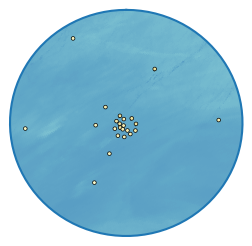

In [415]:
map_projection = ccrs.NorthPolarStereo(central_longitude=210)
fig, ax = plt.subplots(figsize=(3,3), subplot_kw=dict(projection=map_projection))

# set extent
# ax.set_extent([0, 359, 60, 90], ccrs.PlateCarree())
# ax.set_extent([0, 359, 60, 90], ccrs.PlateCarree())
# extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]


ImageDate = datetime(year=2021, month=3, day=20, hour=0)

# buoys
#======================
buoy_lons, buoy_lats, buoy_u, buoy_v = grab_buoy_velocities(ImageDate, ds, buoy_time)

center_lat = buoy_lats[0]
center_lon = buoy_lons[0]
buffer_lon = 3
buffer_lat = buffer_lon*np.cos(center_lat*np.pi/180)

extent = [center_lon-buffer_lon, center_lon+buffer_lon,
          center_lat-buffer_lat, center_lat+buffer_lat]
ax.set_extent(extent, ccrs.PlateCarree())
# ax.set_extent([100, 260, 69, 72], ccrs.PlateCarree())
# ax.set_extent([-190, -11, 69, 71], ccrs.PlateCarree())
# Compute a circle in axes coordinates, use as a boundary for the map. 
# Pan/zoom - the boundary will be permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

sp=1

ax.pcolormesh(lon[0][::sp,::sp], lat[0][::sp,::sp],  _image_[0][::sp,::sp].data, 
              cmap=cmocean.cm.ice_r, shading='nearest', zorder=1, transform=ccrs.PlateCarree(), 
              clip_path=(circle, ax.transAxes))
ax.coastlines()

ax.spines['geo'].set_linewidth(3)
ax.spines['geo'].set_edgecolor('k')


# buoys
#======================
buoy_lons, buoy_lats, buoy_u, buoy_v = grab_buoy_velocities(ImageDate, ds, buoy_time)
buoy_speed = np.sqrt(buoy_u**2+buoy_v**2)
ax.quiver(buoy_lons, buoy_lats, *fix_cartopy_vectors(buoy_u, buoy_v, buoy_lats),
          scale=300, width=0.0025, headwidth=5, transform=ccrs.PlateCarree(), zorder=8)
ax.scatter(buoy_lons, buoy_lats, s=7,
           c=buoy_speed, cmap=cmocean.cm.speed,vmin=0, vmax=40,
           edgecolor='k', lw=0.5, transform=ccrs.PlateCarree(), zorder=9)

ax.plot(out[:,0], out[:,1], transform=ax.transAxes)

ax.set_clip_path(circle, transform=ax.transAxes)

plt.show()

In [419]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

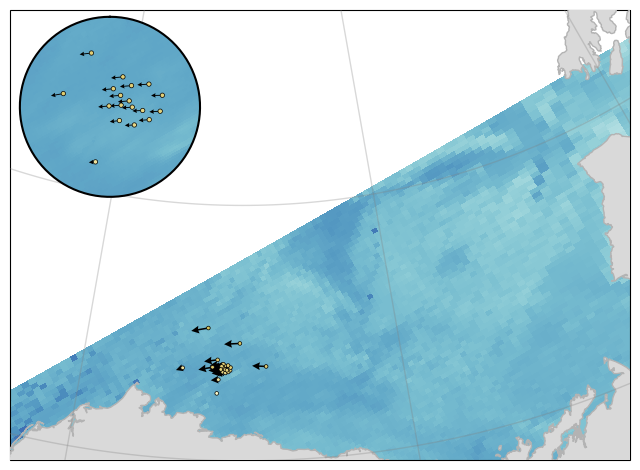

In [481]:
lat_range = [69.5, 78]
lon_range = [197, 232]
extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection), figsize=(8,8), facecolor='white')
ax.set_extent(extent, crs=ccrs.PlateCarree())

sp=10
ax.pcolormesh(lon[0][::sp,::sp], lat[0][::sp,::sp],  _image_[0][::sp,::sp].data, 
              cmap=cmocean.cm.ice_r, shading='nearest', zorder=1, transform=ccrs.PlateCarree())

#======================
# ADD CARTOPY FEATURES
#======================
add_land(ax,  scale='10m', color=[0.85,0.85,0.85], alpha=1, fill_dateline_gap=True, zorder=3)
add_coast(ax, scale='10m', color=[0.7,0.7,0.7], linewidth=1, alpha=1, zorder=4)
add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=10)

buoy_lons, buoy_lats, buoy_u, buoy_v = grab_buoy_velocities(ImageDate, ds, buoy_time)
buoy_speed = np.sqrt(buoy_u**2+buoy_v**2)

ax.quiver(buoy_lons, buoy_lats, *fix_cartopy_vectors(buoy_u, buoy_v, buoy_lats),
          scale=300, width=0.0025, headwidth=5, transform=ccrs.PlateCarree(), zorder=8)
ax.scatter(buoy_lons, buoy_lats, s=7,
           c=buoy_speed, cmap=cmocean.cm.speed,vmin=0, vmax=40,
           edgecolor='k', lw=0.5, transform=ccrs.PlateCarree(), zorder=9)

ImageDate = datetime(year=2021, month=4, day=15, hour=0)

# inset map
#======================
# create inset plots
#-------------------
size = 0.4
axins = inset_axes(ax, width="100%", height="100%", loc='upper left',
                   bbox_to_anchor=(-0.05,0.6,size,size), bbox_transform=ax.transAxes, 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=map_projection))
# buoys
#======================
buoy_lons, buoy_lats, buoy_u, buoy_v = grab_buoy_velocities(ImageDate, ds_local, buoy_time)
buoy_speed = np.sqrt(buoy_u**2+buoy_v**2)
center_lat = buoy_lats[0]-0.025
center_lon = buoy_lons[0]-0.2
buffer_lon = 1
buffer_lat = buffer_lon*np.cos(center_lat*np.pi/180)
extent = [center_lon-buffer_lon, center_lon+buffer_lon,
          center_lat-buffer_lat, center_lat+buffer_lat]
axins.set_extent(extent, ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axins.set_boundary(circle, transform=axins.transAxes)

# for each file in _image_ list
for ii in range(0,len(_image_)):
    axins.pcolormesh(lon[ii], lat[ii], _image_[ii],
                     cmap=cmocean.cm.ice_r, shading='nearest', zorder=1, transform=ccrs.PlateCarree(), 
                     clip_path=(circle, axins.transAxes))

# buoys
#======================
axins.quiver(buoy_lons, buoy_lats, *fix_cartopy_vectors(buoy_u, buoy_v, buoy_lats),
          scale=100, width=0.005, headwidth=5, transform=ccrs.PlateCarree(), zorder=8)
axins.scatter(buoy_lons, buoy_lats, s=10,
           c=buoy_speed, cmap=cmocean.cm.speed,vmin=0, vmax=40,
           edgecolor='k', lw=0.5, transform=ccrs.PlateCarree(), zorder=9)
axins.plot(out[:,0], out[:,1], c='k', transform=axins.transAxes)

plt.show()

In [25]:

map_proj = ccrs.NearsidePerspective(central_longitude=205.0, central_latitude=80.0, satellite_height=2500000)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(4,3))
ax.set_global()
# ax.coastlines(color='gray', zorder=2)
add_land(ax,  scale='50m', color=[0.85,0.85,0.85], alpha=1, fill_dateline_gap=True, zorder=3)
# ax.set_extent([], crs=ccrs.PlateCarree())

# IMPORT ERA5
#=============
# grab nearest date index from ECMWF_winds file
rounded_date = ImageDate-timedelta(minutes = ImageDate.minute)
if not quiet:
    print('Add wind data: nearest date ECMWF_winds --> {}'.format(rounded_date))
ds_era = xr.open_dataset(ECMWF).sel(time=rounded_date)
ds_era.close()
u10  = ds_era.u10.values
v10  = ds_era.v10.values
msl  = ds_era.msl.values/100
Lons, Lats = np.meshgrid(ds_era.longitude.values, ds_era.latitude.values)


ax.pcolormesh(Lons, Lats, msl, cmap=cmocean.cm.matter, vmin=1000, vmax = 1060, zorder=1, transform=ccrs.PlateCarree())
ax.contour(Lons, Lats, msl, colors='k', linewidths=0.5, levels=np.arange(980,1080,4), zorder=1, transform=ccrs.PlateCarree())


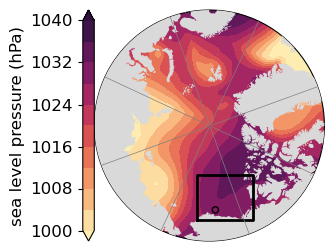

In [204]:
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, AX = plt.subplots(figsize=(3,3), subplot_kw=dict(projection=map_projection))


# set extent
AX.set_extent([0, 359, 65, 90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, use as a boundary for the map. 
# Pan/zoom - the boundary will be permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
AX.set_boundary(circle, transform=AX.transAxes)


mesh = AX.contourf(Lons, Lats, msl, cmap=cmocean.cm.matter, vmin=1000, vmax = 1040, 
                   extend='both', levels=np.arange(1000,1044,4), zorder=1, transform=ccrs.PlateCarree())

add_land(AX,  scale='50m', color=[0.85,0.85,0.85], alpha=1, fill_dateline_gap=True, zorder=3)
add_grid(AX, lats=np.arange(60,90,30), lons=np.arange(0,360,45), 
         linewidth=0.5, color='gray', alpha=1, zorder=4)

add_colorbar(fig, AX, [mesh], cb_placement='left', cb_orientation='auto', 
             cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0, cb_ticks='auto', 
             cb_ticklabels='auto', cb_extend='neither', cb_label='sea level pressure (hPa)', labelpad='auto',
             cb_label_placement='auto', cb_tick_placement='auto', cb_labelsize=12, 
             draw_edges=False, edge_params=['k', 2])

AX.plot([map_extent[0],map_extent[0],map_extent[1],map_extent[1],map_extent[0]], 
        [map_extent[2],map_extent[3],map_extent[3],map_extent[2],map_extent[2]], 
        c='k', lw=2, alpha=1, zorder=3)


# ax.plot(out[:,0], out[:,1], c='k', lw=2, transform=axins.transAxes, zorder=10)

# AX.plot(out[:,0],out[:,1], c='blue', transform=ax.transAxes, zorder=10)

# AX.plot(all_lons, all_lats, transform=ccrs.PlateCarree())
AX.scatter(all_lons[-1], all_lats[-1], s=20, facecolor='None', edgecolor='k', transform=ccrs.PlateCarree())

# AX.scatter(out[:,0], out[:,1], s=20, facecolor='None', edgecolor='k')#, transform=ax)

In [201]:
AX.get_extent()

(-2814043.4154944746,
 2790699.493523568,
 -2803418.861161509,
 2822560.8095903127)

In [203]:
ax.get_extent()

(-50000000.0, 50000000.0, -49969541.350954786, 49969541.350954786)

In [196]:
out

array([[5.00000000e-01, 1.00000000e+00],
       [5.31711960e-01, 9.98993338e-01],
       [5.63296227e-01, 9.95977406e-01],
       [5.94625622e-01, 9.90964349e-01],
       [6.25573994e-01, 9.83974351e-01],
       [6.56016723e-01, 9.75035559e-01],
       [6.85831228e-01, 9.64183967e-01],
       [7.14897456e-01, 9.51463269e-01],
       [7.43098368e-01, 9.36924689e-01],
       [7.70320409e-01, 9.20626766e-01],
       [7.96453965e-01, 9.02635129e-01],
       [8.21393805e-01, 8.83022222e-01],
       [8.45039506e-01, 8.61867019e-01],
       [8.67295854e-01, 8.39254706e-01],
       [8.88073232e-01, 8.15276334e-01],
       [9.07287976e-01, 7.90028455e-01],
       [9.24862715e-01, 7.63612734e-01],
       [9.40726682e-01, 7.36135537e-01],
       [9.54815998e-01, 7.07707507e-01],
       [9.67073930e-01, 6.78443111e-01],
       [9.77451121e-01, 6.48460188e-01],
       [9.85905784e-01, 6.17879468e-01],
       [9.92403877e-01, 5.86824089e-01],
       [9.96919232e-01, 5.55419100e-01],
       [9.994336

In [202]:
lat_range = [69.5, 78]
lon_range = [197, 232]
extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(3,3), subplot_kw=dict(projection=map_projection))

In [180]:
# convert from data to cartesian coordinates
target = ccrs.PlateCarree()
p_a_cart = target.transform_point(*p_a_data, src_crs=map_projection)


In [177]:
p_a_disp = ax.transAxes.transform(p_a_data)
p_a_disp

array([4.84136033e-01, 2.51728808e-04])

In [176]:
p_a_data = ax.transData.inverted().transform((out[50,0], out[50,1]))
p_a_data

array([-0.16050946, -0.30225955])

In [181]:
p_a_cart

(177.03027294832873, 89.9999969359672)

In [147]:
(out[0,0], out[0,1])

(0.5, 1.0)

In [122]:
axins2.set_boundary(circle, transform=axins2.transAxes)


(0.5, 1.0)

In [126]:
axins.get_extent()

(-50000000.0, 50000000.0, -49969541.350954786, 49969541.350954786)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.80000e+01, 6.46000e+02, 6.63300e+03, 1.67860e+04,
        2.60620e+04, 3.40250e+04, 3.66830e+04, 6.59400e+04, 9.29640e+04,
        1.27755e+05, 1.09186e+05, 5.22090e+04, 4.22620e+04, 5.54160e+04,
        6.00900e+04, 3.31970e+04, 1.15320e+04, 3.17600e+03, 2.00900e+03,
        1.45400e+03, 1.09600e+03, 1.48600e+03, 1.57000e+03]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
        3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
        4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9]

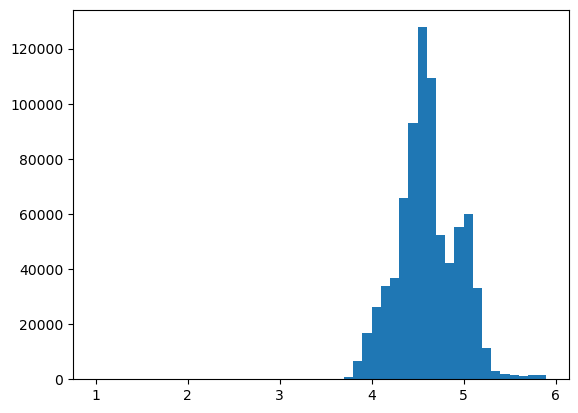

In [13]:
plt.hist(all_rad[cond == 4], bins=np.arange(1,6,0.1))

In [14]:
#         if ImageDate <= datetime(2021, 4, 15, 18, 0):
#             cscale = [3, 6.5]
#         elif ImageDate <= datetime(2021, 4, 16, 5, 0):
#             cscale = [3.2, 6.6]
#         elif ImageDate <= datetime(2021, 4, 16, 16, 0):
#             cscale = [3, 6.5]
#         elif ImageDate <= datetime(2021, 4, 16, 18, 0):
#             cscale = [3.15, 6.65]
#         elif ImageDate <= datetime(2021, 4, 16, 22, 0):
#             cscale = [3.4, 6.8]
#         elif ImageDate <= datetime(2021, 4, 17, 10, 0):
#             cscale = [3.5, 6.8]
#         elif ImageDate <= datetime(2021, 4, 17, 18, 0):
#             cscale = [3.6, 6.8]
#         else:

In [15]:
# #======================
#         # ADD BUOY COORDINATES
#         #======================
#         if csv_directory != None:

#             # plot buoy drift
#             #----------------
#             buffer_hours = 0.5
#             for buoy_file in csv_files:

#                 # Get the camp position at the image acquisition time
#                 ([lon_buoy, lat_buoy], hour_diff) = GetCampPosition_cln(buoy_file, ImageDate)            

#                 # if date within buoy time range, plot nearest point
#                 if lat_buoy != -999 and abs(hour_diff) < buffer_hours:
#                     if lon_buoy < 0:
#                         lon_buoy += 360

#                     # plot point (from GetCampPosition_cln)
#                     ax.scatter(lon_buoy, lat_buoy, 
#                                linewidth=0.2, marker='.', facecolor='deepskyblue', edgecolor='blue',s=5,
#                                transform=ccrs.PlateCarree(), zorder=8)

#                     # re-open data and crop to find drift over desired time range
#                     #------------------------------------------------------------
#                     out = open_buoy_data(buoy_file, 
#                                          start_date = ImageDate-timedelta(hours=0.25), 
#                                          end_date = ImageDate+timedelta(hours=0.25))
#                     lon_track, lat_track, time_track, df_buoy = out


#                     if len(df_buoy) > 0:

#                         # grab first and last times of day
#                         lon_single = np.array([lon_track[0],lon_track[-1]])
#                         lat_single = np.array([lat_track[0],lat_track[-1]])
#                         time_single = np.array([time_track[0],time_track[-1]])

#                         # calculate velocity
#                         u, v, time, dx, dy, dist = calc_velocity(lon_track=lon_single, 
#                                                                  lat_track=lat_single, 
#                                                                  time_track=time_single, 
#                                                                  step=1)
                        
#                         # time diff between image and velocity
#                         DT = abs((time[0]-ImageDate).total_seconds())/60

#                         if DT > 20:
#                             COL = 'green'
#                         else:
#                             COL = 'deepskyblue'
#                         # plot drift vector from open_buoy_data / calc_velocity
#                         ax.quiver(np.array([lon_buoy]), np.array([lat_buoy]), 
#                                   *fix_cartopy_vectors(u.magnitude,v.magnitude,np.array([lat_buoy])), 
#                                   scale=300, alpha=0.75, width=0.001, color=COL, 
#                                   edgecolor=COL, lw=0.5, transform=ccrs.PlateCarree(), zorder=2)



In [16]:
# map_projection = ccrs.NorthPolarStereo(central_longitude=210)

# # narrow around SIDEX camp
# lon_range = [200, 230]   # specify lon range to plot
# lat_range = [69.5,75]   # specify lat range to plot


# lat_range = [70.5, 74.5]
# lon_range = [202, 225]


# medium range
# lon_range = [195, 235]   # specify lon range to plot
# lat_range = [68.5,78]   # specify lat range to plot
# map_projection = ccrs.NorthPolarStereo(central_longitude=215)

# wide range for weather overlay
# lon_range = [175, 245]   # specify lon range to plot
# lat_range = [66,89]   # specify lat range to plot


# for masters presentation
# v1
# lon_range = [192.5, 232.5]   # specify lon range to plot
# lat_range = [68.75,78]   # specify lat range to plot
# wider
# lon_range = [170, 245]   # specify lon range to plot
# lat_range = [65,85]   # specify lat range to plot

# map_projection
#==============================================================
# north polar stereographic
# map_projection = ccrs.NorthPolarStereo(central_longitude=210)#ccrs.NorthPolarStereo(central_longitude=215)
# bad projection kenzie is using:
# map_projection = ccrs.PlateCarree(central_longitude=180)
# below add: shading='nearest', to make plot
#==============================================================
# Albers_CCRS = ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
#                                     false_easting=0.0, false_northing=0.0, 
#                                     standard_parallels=(55, 65))